# Street View House Numbers Classification

The Street View House Numbers (SVHN) dataset is one of the most popular benchmarks for object recognition tasks in academic papers. The images were obtained from house numbers in Google Street View images, are hosted by Stanford University and are very similar in philosophy with the MNIST dataset. However, the original purpose of this dataset is to solve a harder problem: that of recognizing digits and numbers in natural scene images.

## 1. Imports

In [1]:

from __future__ import print_function
import numpy as np
import keras
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras. layers import Conv2D, MaxPooling2D, Activation
from keras import backend as K
from keras import regularizers
import tensorflow  as tf
#from keras.layers import *
from keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt


%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random state

np.random.seed(20)

## 2. Loading and preprocessing

In [3]:
# Load the data

train_raw = loadmat('../input/svhndataset/train_32x32.mat')
test_raw = loadmat('../input/svhndataset/test_32x32.mat')

In [4]:
# Load images and labels

train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [5]:
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [6]:
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


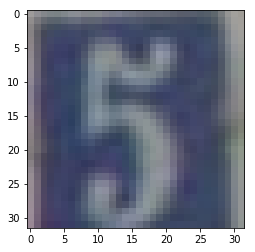

Label:  [5]


In [7]:
# Plot a random image and its label

plt.imshow(train_images[13529])
plt.show()

print('Label: ', train_labels[13529])

In [8]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

In [9]:
# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [10]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 0.0, Max: 255.0


In [11]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [12]:
# Split train data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [13]:
y_val.shape

(10989, 10)

## 3. CNN model

In order to get more robust results out of our model, we are going to augment the images in the dataset, by randomly rotating them, zooming them in and out, shifting them up and down (**IMPORTANT NOTE:** It is best that we do not shift them horizontally, since there are also distracting digits in the images), shifting their channels and shearing them.

In [14]:
# Data augmentation

datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

In order to determine a good learning rate for the optimizer of our model (here, we use the AMSGrad variant of the Adam optimizer), we set a callback in an auxillary model which will gradually increase the learning rate of the optimizer.

In [15]:
input_shape = (32,32,3)
batch_size = 128 # Batch-Size
num_classes = 10 # Number of Class
epochs = 20 # Number of epoch
w_l2 = 1e-5 # Initial

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

We can see that the loss follows a very specific trajectory: a rapid drop followed by a relatively flat line which shoots back up after a certain point. Thus, it is better to choose a learning rate in the region where the loss is stable; a reasonable choice would be **lr = 0.01** (or 1e-3).

## ReLU model

In [17]:
# ReLU model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)       

In [19]:
# Fit model in order to make predictions

hist_relu = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70
487/487 [==============================] - 37s 76ms/step - loss: 2.0799 - accuracy: 0.2323 - val_loss: 1.5425 - val_accuracy: 0.4535
Epoch 2/70
487/487 [==============================] - 33s 67ms/step - loss: 1.4329 - accuracy: 0.4568 - val_loss: 0.5803 - val_accuracy: 0.8428
Epoch 3/70
487/487 [==============================] - 33s 68ms/step - loss: 0.7428 - accuracy: 0.7640 - val_loss: 0.3508 - val_accuracy: 0.8966
Epoch 4/70
487/487 [==============================] - 33s 67ms/step - loss: 0.4668 - accuracy: 0.8648 - val_loss: 0.3302 - val_accuracy: 0.9042
Epoch 5/70
487/487 [==============================] - 33s 67ms/step - loss: 0.3983 - accuracy: 0.8858 - val_loss: 0.2577 - val_accuracy: 0.9274
Epoch 6/70
487/487 [==============================] - 33s 68ms/step - loss: 0.3559 - accuracy: 0.8988 - val_loss: 0.2467 - val_accuracy: 0.9323
Epoch 7/70
487/487 [==============================] - 33s 67ms/step - loss: 0.3256 - accuracy: 0.9073 - val_loss: 0.2629 - val_accuracy:

## Sigmoid model

In [20]:
# Sigmoid model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='sigmoid',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='sigmoid'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='sigmoid'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='sigmoid'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# Fit model in order to make predictions

hist_sigmoid = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70
487/487 [==============================] - 34s 70ms/step - loss: 2.2014 - accuracy: 0.2012 - val_loss: 2.0335 - val_accuracy: 0.3071
Epoch 2/70
487/487 [==============================] - 33s 67ms/step - loss: 0.9798 - accuracy: 0.6871 - val_loss: 0.4376 - val_accuracy: 0.8706
Epoch 3/70
487/487 [==============================] - 33s 67ms/step - loss: 0.5075 - accuracy: 0.8458 - val_loss: 0.3166 - val_accuracy: 0.9051
Epoch 4/70
487/487 [==============================] - 33s 67ms/step - loss: 0.4068 - accuracy: 0.8778 - val_loss: 0.3499 - val_accuracy: 0.8933
Epoch 5/70
487/487 [==============================] - 32s 66ms/step - loss: 0.3626 - accuracy: 0.8904 - val_loss: 0.2733 - val_accuracy: 0.9192
Epoch 6/70
487/487 [==============================] - 33s 67ms/step - loss: 0.3324 - accuracy: 0.9006 - val_loss: 0.2408 - val_accuracy: 0.9317
Epoch 7/70
487/487 [==============================] - 33s 67ms/step - loss: 0.3104 - accuracy: 0.9076 - val_loss: 0.2289 - val_accuracy:

## Tanh model

In [22]:
# Tanh model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='tanh',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='tanh'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='tanh'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='tanh'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='tanh'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='tanh'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# Fit model in order to make predictions

hist_tanh = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70
487/487 [==============================] - 34s 70ms/step - loss: 1.8230 - accuracy: 0.3947 - val_loss: 0.7338 - val_accuracy: 0.7731
Epoch 2/70
487/487 [==============================] - 33s 67ms/step - loss: 0.7610 - accuracy: 0.7650 - val_loss: 0.4834 - val_accuracy: 0.8542
Epoch 3/70
487/487 [==============================] - 33s 67ms/step - loss: 0.5953 - accuracy: 0.8193 - val_loss: 0.3858 - val_accuracy: 0.8852
Epoch 4/70
487/487 [==============================] - 33s 67ms/step - loss: 0.5188 - accuracy: 0.8428 - val_loss: 0.3469 - val_accuracy: 0.8974
Epoch 5/70
487/487 [==============================] - 33s 67ms/step - loss: 0.4728 - accuracy: 0.8591 - val_loss: 0.3258 - val_accuracy: 0.9019
Epoch 6/70
487/487 [==============================] - 33s 68ms/step - loss: 0.4334 - accuracy: 0.8688 - val_loss: 0.3398 - val_accuracy: 0.8966
Epoch 7/70
487/487 [==============================] - 33s 68ms/step - loss: 0.4141 - accuracy: 0.8749 - val_loss: 0.2849 - val_accuracy:

## LeakyReLU model

In [24]:
from keras.layers.advanced_activations import LeakyReLU

In [25]:
# Define actual model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='linear',
                           input_shape=(32, 32, 3)),
    LeakyReLU(alpha=.001),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='linear'),
    LeakyReLU(alpha=.001),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='linear'),
    LeakyReLU(alpha=.001),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='linear'),
    LeakyReLU(alpha=.001),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='linear'),
    LeakyReLU(alpha=.001),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='linear'),
    LeakyReLU(alpha=.001),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='linear'),
    LeakyReLU(alpha=.001),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
# Fit model in order to make predictions

hist_LeakyReLU = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=70, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/70
487/487 [==============================] - 34s 69ms/step - loss: 2.1448 - accuracy: 0.2266 - val_loss: 1.6567 - val_accuracy: 0.3999
Epoch 2/70
487/487 [==============================] - 32s 67ms/step - loss: 1.2443 - accuracy: 0.5666 - val_loss: 0.4859 - val_accuracy: 0.8523
Epoch 3/70
487/487 [==============================] - 33s 67ms/step - loss: 0.6165 - accuracy: 0.8152 - val_loss: 0.3529 - val_accuracy: 0.9003
Epoch 4/70
487/487 [==============================] - 32s 66ms/step - loss: 0.4594 - accuracy: 0.8666 - val_loss: 0.3034 - val_accuracy: 0.9146
Epoch 5/70
487/487 [==============================] - 33s 67ms/step - loss: 0.3990 - accuracy: 0.8853 - val_loss: 0.2525 - val_accuracy: 0.9322
Epoch 6/70
487/487 [==============================] - 32s 67ms/step - loss: 0.3605 - accuracy: 0.8959 - val_loss: 0.2341 - val_accuracy: 0.9379
Epoch 7/70
487/487 [==============================] - 33s 67ms/step - loss: 0.3309 - accuracy: 0.9041 - val_loss: 0.2315 - val_accuracy:

In [27]:
def plot_history(hists, attribute='val_loss', axis=(-1,21,0.85,0.94), loc='lower right'):
    ylabel = {'oss': 'loss', 'acc': 'accuracy'}
    title = {'val_loss': 'valid. loss', 'loss': 'trn. loss', 'val_accuracy': 'valid. accuracy', 'accuracy': 'trn. accuracy'}
    num_hists = len(hists)
    
    plt.figure(figsize=(12, 8))  
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(title[attribute])  
    #plt.ylabel(ylabel[attribute[-3:]])  
    plt.xlabel('epoch')  
    plt.legend(['Sigmoid', 'tanh', 'ReLU', 'Leaky_ReLU'], loc=loc)  
    plt.savefig(attribute + '.png')
    plt.show()

In [28]:
hists = [hist_sigmoid, hist_tanh, hist_relu, hist_LeakyReLU]

In [29]:
hist_sigmoid.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

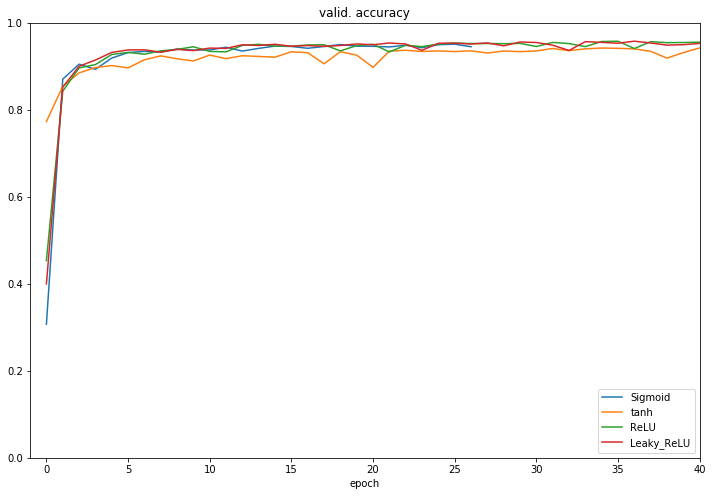

In [30]:
plot_history(hists, attribute='val_accuracy',axis=(-1,40,0,1), loc='lower right')

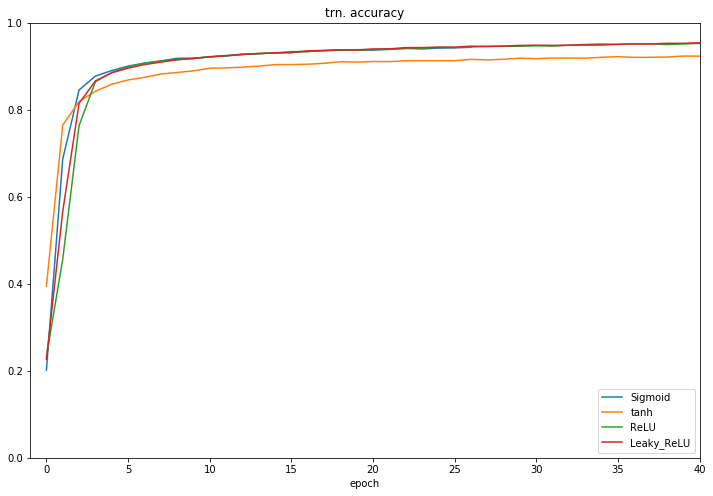

In [31]:
plot_history(hists, attribute='accuracy',axis=(-1,40,0,1), loc='lower right')

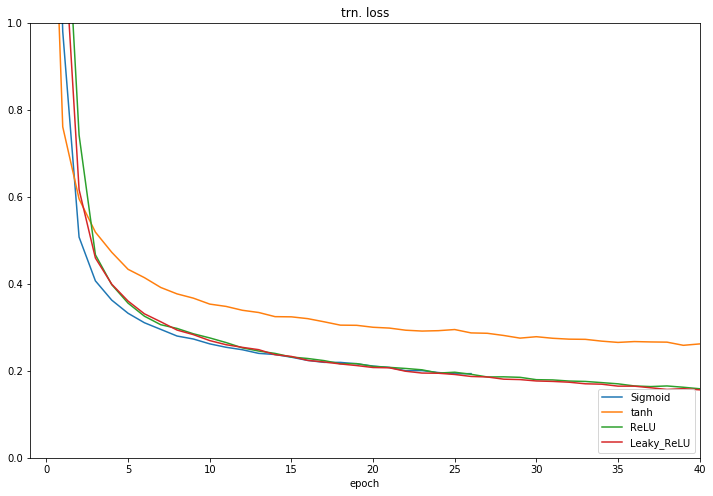

In [32]:
plot_history(hists, attribute='loss',axis=(-1,40,0,1), loc='lower right')

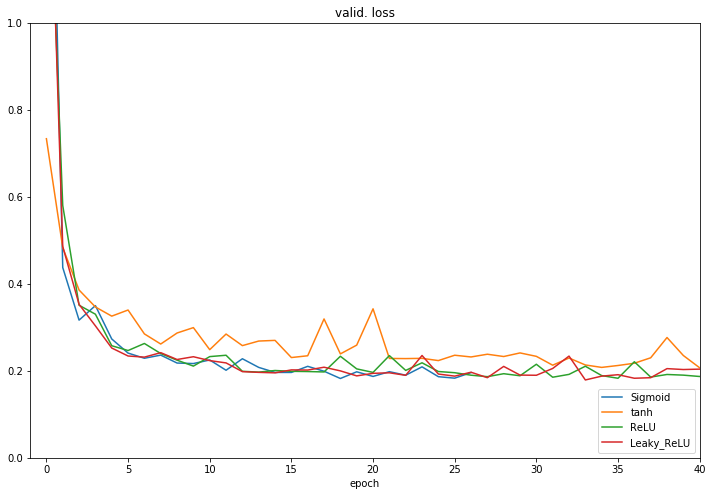

In [33]:
plot_history(hists, attribute='val_loss',axis=(-1,40,0,1), loc='lower right')

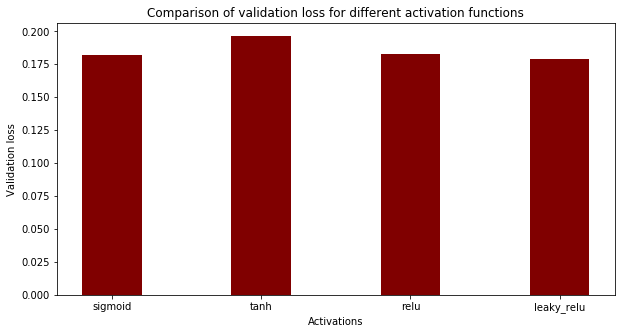

In [34]:
data = {
    'sigmoid': min(hist_sigmoid.history['val_loss']),
    'tanh' : min(hist_tanh.history['val_loss']),
    'relu' : min(hist_relu.history['val_loss']),
    'leaky_relu' : min(hist_LeakyReLU.history['val_loss'])
}

activations = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(activations, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Activations")
plt.ylabel("Validation loss")
plt.title("Comparison of validation loss for different activation functions")
scale_factor = 1

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

#plt.xlim(xmin * scale_factor, xmax * scale_factor)
#plt.ylim(ymin * scale_factor, ymax * scale_factor)
plt.show()

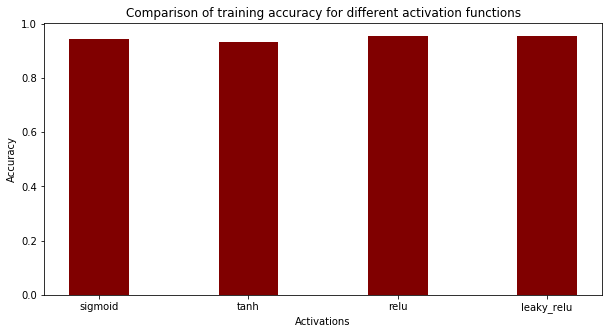

In [35]:
data = {
    'sigmoid': max(hist_sigmoid.history['accuracy']),
    'tanh' : max(hist_tanh.history['accuracy']),
    'relu' : max(hist_relu.history['accuracy']),
    'leaky_relu' : max(hist_LeakyReLU.history['accuracy'])
}

activations = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(activations, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Activations")
plt.ylabel("Accuracy")
plt.title("Comparison of training accuracy for different activation functions")
scale_factor = 1

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

#plt.xlim(xmin * scale_factor, xmax * scale_factor)
#plt.ylim(ymin * scale_factor, ymax * scale_factor)
plt.show()

## 5. Conclusion

In this kernel, we have trained a Convolutional Neural Network to recognize the digits in the Street View House Numbers dataset (Format 2). In particular, we have performed some minimal preprocessing of the data, we have augmented the data in various ways, we have created an auxillary model in order to find which learning rate we should choose for our optimizer and finally, we have trained the final CNN and evaluated it on the test images data. Finally, it should be noted that there is quite a bit of room for tuning and different architectures so as to improve the accuracy of the model; nonetheless, our results are pretty good given the simplicity of our approach.